In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns


import sys
import importlib
sys.path.append('../../')
import helper

In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available and being used


# Prepare Dataset 

In [3]:
importlib.reload(helper)
path_to_data = '../../datasets/ddos/01-12/'
samples_per_file = 1000
df = helper.get_ddos_data_cleaned(path = path_to_data, num_rows = samples_per_file)
df.rename(columns={'Label':'Attack Type'}, inplace=True)

#removes 0 in protocol rows this should not be done if not classifying on protocol
df = df[df[' Protocol'] != 0]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10686 entries, 0 to 999
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0    Protocol                     10686 non-null  int64  
 1    Flow Duration                10686 non-null  int64  
 2    Total Fwd Packets            10686 non-null  int64  
 3    Total Backward Packets       10686 non-null  int64  
 4   Total Length of Fwd Packets   10686 non-null  float64
 5    Total Length of Bwd Packets  10686 non-null  float64
 6    Fwd Packet Length Max        10686 non-null  float64
 7    Fwd Packet Length Min        10686 non-null  float64
 8    Fwd Packet Length Mean       10686 non-null  float64
 9    Fwd Packet Length Std        10686 non-null  float64
 10  Bwd Packet Length Max         10686 non-null  float64
 11   Bwd Packet Length Min        10686 non-null  float64
 12   Bwd Packet Length Mean       10686 non-null  float64
 13   Bw

/mnt/d/CMU/CMU-projects/FlowClassification/multi-task/ddos/../../helper.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  dataset1 = dataset1[~dataset1.isin([np.nan, np.inf, -np.inf]).any(1)]


### Understanding ddos dataset & CIC flowmeter
Protocol: 17-UDP 6-TCP 0-Other/Unknown  
Flow Duration: measured in microseconds

In [113]:
targets = [
    'Attack Type',
    ' Protocol'
]

print(df.shape)
print(df.dtypes.value_counts())
print(df[targets[0]].value_counts())
print(df[targets[1]].value_counts())

(10686, 68)
float64    45
int64      22
object      1
dtype: int64
BENIGN     1081
SNMP        997
UDP-lag     997
LDAP        993
SSDP        993
MSSQL       980
NetBIOS     971
UDP         964
Syn         912
TFTP        884
DNS         632
NTP         282
Name: Attack Type, dtype: int64
17    8003
6     2683
Name:  Protocol, dtype: int64


In [91]:
# encode the labels of the targets
le1 = LabelEncoder()
df[targets[0]] = le1.fit_transform(df[targets[0]])
# Create a dictionary to map the original labels to their encoded values
encoded_to_label = {encoded: label for label, encoded in zip(le1.classes_, le1.transform(le1.classes_))}

le2 = LabelEncoder()
df[targets[1]] = le2.fit_transform(df[targets[1]])




In [92]:
print(encoded_to_label)

{0: 'BENIGN', 1: 'DNS', 2: 'LDAP', 3: 'MSSQL', 4: 'NTP', 5: 'NetBIOS', 6: 'SNMP', 7: 'SSDP', 8: 'Syn', 9: 'TFTP', 10: 'UDP', 11: 'UDP-lag'}


# Beyond here you dont have to mess with the dataframe anymore.

### Structure data for pytorch and split into training and testing splits

In [94]:
# dataset wrapper for the dataframe. Just a way to structure the data that pytorch likes and needs to then wrap with dataloader.

class DatasetWrapper(Dataset):
    def __init__(self, df : pd.DataFrame, target : str):
        self.n = df.shape[0]
        
        self.y = df[target].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=targets)).astype(np.float32)

    def __len__(self):
        return self.n
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
exp_dataset = DatasetWrapper(df, target=targets) # UPDATE for your experiments

# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 8548, Test length: 2138


In [95]:
print(df.shape)
print(df.dtypes.value_counts())

(10686, 68)
float64    45
int64      23
dtype: int64


In [96]:
##Find the number of features
print(f"Features: {len(train_dataset[0][0])}")
print(f"Targets: {len(train_dataset[0][1])}")

Features: 66
Targets: 2


### Prepare Model

In [97]:
# All the layers of the model

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_features)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)
        
        # class_embed = self.classification_embedding(torch.tensor([0], device=x.device))  # use index 0 for the classification embedding
        # class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
        # class_embed = class_embed.unsqueeze(1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        # self.lin2 = nn.Linear(2*self.input, 2*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x


# DEFAULT PARAMETERS SET UP FOR MY DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
# All dropout is initially turned off
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_features=66, # YOU WILL PROBABLY NEED TO CHANGE
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4, #widens the mlp in the classification heads
                 targets_classes : list=  [12,2] #put the number of classes in each target variable. traffic type = 3 classes, application type = 8 classes
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_features=n_features, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification, num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw


### Train and Testing Loops

In [98]:
# Training and Testing Loops
# Should not need modification

def train(dataloader, model, loss_functions : list, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (inputs, targets) in dataloader:
        
        inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)

        task_predictions = model(inputs) #contains a list of the tensor outputs for each task

        loss = 0
        for i in range(len(loss_functions)):
          loss += loss_functions[i](task_predictions[i], targets[:,i])
        loss = loss/len(loss_functions)
        total_loss+= loss.item() #just summing the two losses

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == targets[:,0]).sum().item()
        total_samples_1 += targets[:,0].size(0)
        all_targets_1.extend(targets[:,0].cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        #computing accuaracy for second target
        y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
        _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
        total_correct_2 += (y_pred_labels_2 == targets[:,1]).sum().item()
        total_samples_2 += targets[:,1].size(0)
        all_targets_2.extend(targets[:,1].cpu().numpy())
        all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1, accuracy_2
    

def test(dataloader, model, loss_functions : list, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (inputs, targets) in dataloader:
      inputs, targets = inputs.to(device_in_use), targets.to(device_in_use)
      
      #compute prediction error
      task_predictions = model(inputs) #contains a list of the tensor outputs for each task

      loss = 0
      for i in range(len(loss_functions)):
        loss += loss_functions[i](task_predictions[i], targets[:,i])
      loss = loss/len(loss_functions)

      total_loss+= loss.item()

      #computing accuracy for first target
      y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
      _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
      total_correct_1 += (y_pred_labels_1 == targets[:,0]).sum().item()
      total_samples_1 += targets[:,0].size(0)
      all_targets_1.extend(targets[:,0].cpu().numpy())
      all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

      #computing accuaracy for second target
      y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
      _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
      total_correct_2 += (y_pred_labels_2 == targets[:,1]).sum().item()
      total_samples_2 += targets[:,1].size(0)
      all_targets_2.extend(targets[:,1].cpu().numpy())
      all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, accuracy_2, all_predictions_1, all_predictions_2, all_targets_1, all_targets_2, f1_1, f1_2

def format_metric(value): # Used to format the metrics output
    return f"{value:.2f}"

In [99]:
Num_Features = len(train_dataset[0][0])

In [100]:
#Updated with f1
model = Classifier(n_features=Num_Features, pre_norm_on=True, rff_on=True, forward_expansion=1, mlp_scale_classification=2).to(device_in_use) # Instantiate the model
loss_functions = [nn.CrossEntropyLoss(), nn.CrossEntropyLoss()]
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 40 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1, train_accuracy_2 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, test_accuracy_2, all_predictions_1, all_predictions_2, all_targets_1, all_targets_2, f1_1, f1_2 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, Attack Type Accuracy {format_metric(train_accuracy_1)}, Protocol Accuracy {format_metric(train_accuracy_2)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, Attack Type Accuracy {format_metric(test_accuracy_1)}, Protocol Accuracy {format_metric(test_accuracy_2)}, Attack F1 {format_metric(f1_1)}, Protocol F1 {format_metric(f1_2)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


Epoch [ 1/40]        | Train: Loss 1.54, Attack Type Accuracy 0.11, Protocol Accuracy 0.75 | Test: Loss 1.37, Attack Type Accuracy 0.17, Protocol Accuracy 0.74, Attack F1 0.07, Protocol F1 0.63
Epoch [ 2/40]        | Train: Loss 1.12, Attack Type Accuracy 0.32, Protocol Accuracy 0.96 | Test: Loss 0.86, Attack Type Accuracy 0.46, Protocol Accuracy 1.00, Attack F1 0.34, Protocol F1 1.00
Epoch [ 3/40]        | Train: Loss 0.60, Attack Type Accuracy 0.59, Protocol Accuracy 1.00 | Test: Loss 0.44, Attack Type Accuracy 0.63, Protocol Accuracy 1.00, Attack F1 0.55, Protocol F1 1.00
Epoch [ 4/40]        | Train: Loss 0.37, Attack Type Accuracy 0.65, Protocol Accuracy 1.00 | Test: Loss 0.34, Attack Type Accuracy 0.65, Protocol Accuracy 1.00, Attack F1 0.60, Protocol F1 1.00
Epoch [ 5/40]        | Train: Loss 0.32, Attack Type Accuracy 0.67, Protocol Accuracy 1.00 | Test: Loss 0.32, Attack Type Accuracy 0.65, Protocol Accuracy 1.00, Attack F1 0.59, Protocol F1 1.00
Epoch [ 6/40]        | Train: 

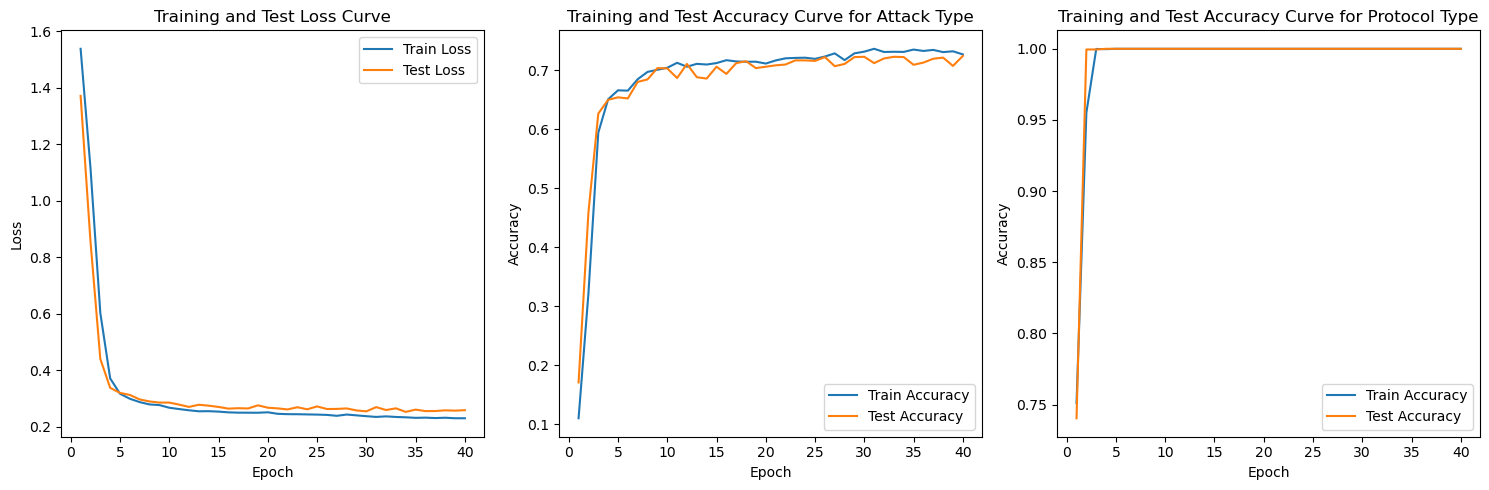

In [101]:
# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for Attack Type')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for Protocol Type')
plt.legend()
plt.tight_layout()
plt.tight_layout()
plt.show()

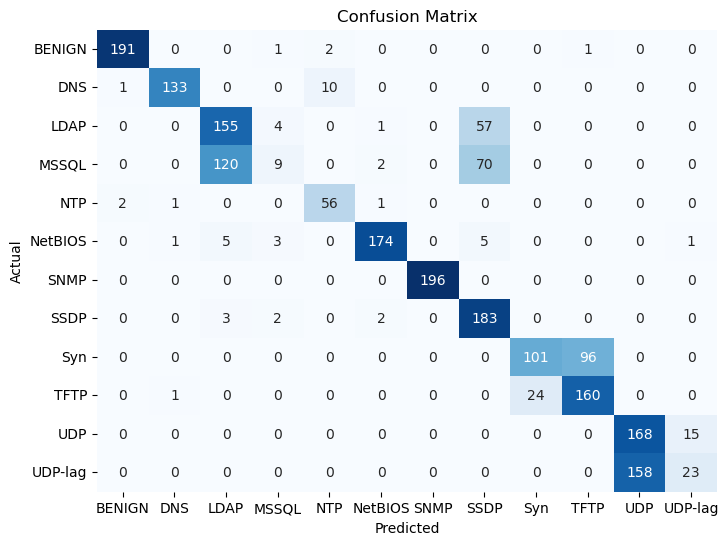

In [105]:
actual_labels = [encoded_to_label[i] for i in sorted(list(set(all_targets_1 + all_predictions_1)))]
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=actual_labels, yticklabels=actual_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [104]:
# Display confusion matrix for the first task (Traffic Type) on test data
#conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
#print("Confusion Matrix for Attack Type")
#print(conf_matrix_1)

# Display confusion matrix for the second task (Application Type) on test data
#conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
#print("Confusion Matrix for Protocol Type")
#print(conf_matrix_2)

In [ ]:
max(test_accuracies_1)

0.7474275023386342